### Importa librerie

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from adjustText import adjust_text
from custom.watermarks import add_watermark

### Definizione funzioni

In [2]:
def get_vaccine_data(country, time_window=30, fully=False):
    """ Recupera dati sulla frazione di vaccinati medi negli ultimi time_window giorni (default = 30)"""
    df_vacc_country2 = df_global[df_global["location"] == country]
    df_vacc_country = df_vacc_country2.fillna(method='ffill').copy()
    if fully==False:
        vacc_fully = np.array(df_vacc_country["people_vaccinated_per_hundred"][-(time_window+1):-1])
    else:
        vacc_fully = np.array(df_vacc_country["people_fully_vaccinated_per_hundred"][-(time_window+1):-1])
    
    vacc_ultimi_Ngiorni = np.mean(vacc_fully)   
    return vacc_ultimi_Ngiorni

def get_deaths(country, time_window=30):
    """ Recupera dati sul numero assoluto di decessi negli ultimi time_window giorni (default = 30)"""
    decessi = np.array(df_global[df_global["location"] == country]['total_deaths'])
    decessi_ultimi_Ngiorni = decessi[-1] - decessi[-(time_window+1)]
    return decessi_ultimi_Ngiorni

def get_value_from_df(countries, column, scale_factor=1):
    """ Recupera l'ultimo valore della column specificata, per la lista di countries, e moltiplica per scale_factor (default = 1)"""
    values = []
    for el in countries:
         values.append(df_global[df_global["location"] == el][column].tolist()[-1]*scale_factor)
    return values

def remove_nan_two_lists(list_source, list_target):
    """ Rimuove dalla lista_target gli elementi che nella lista_source sono nan. Le due liste possono coincidere"""
    for i, el in enumerate(list_source):
        if str(el) == 'nan':
            list_target.pop(i)
    return list_target

### Importa dati da Our World in Data

In [3]:
file_owid = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'
df_global = pd.read_csv(file_owid)

In [4]:
#DEBUGONLY
# df_global[df_global['location']=='Italy'].tail()
# df_global.columns
# df_global['location'].unique()

In [5]:
# Dataframe solo per paesi europei
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 
                'France', 'Germany', 'Greece', 'Hungary', 'Ireland', 'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 
                'Malta', 'Netherlands', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia', 'Spain', 'Sweden']
df_europe = df_global.loc[df_global['location'].isin(eu_countries)]

In [6]:
#DEBUGONLY
# df_europe[df_europe['location']=='Luxembourg'].tail(30)['people_vaccinated_per_hundred'].tolist()

### Calcola morti e vaccinati

In [7]:
# Definizione paesi e relative label
paesi = eu_countries
paesi_label = ['Austria', 'Belgio', 'Bulgaria', 'Croazia', 'Cipro', 'Repubblica Ceca', 'Danimarca', 'Estonia', 'Finlandia', 
                'Francia', 'Germania', 'Grecia', 'Ungheria', 'Irlanda', 'Italia', 'Lettonia', 'Lituania', 'Lussemburgo', 
                'Malta', 'Paesi Bassi', 'Polonia', 'Portogallo', 'Romania', 'Slovacchia', 'Slovenia', 'Spagna', 'Svezia']

# Calcola vaccinati e decessi
abitanti = get_value_from_df(paesi, 'population', scale_factor=1e-6)

# create a dictionary. This is the safest option ! 
abitanti_dict = dict(zip(paesi, abitanti))

In [8]:
dec_res=[] # Decessi per milione di abitanti ultimi tw giorni
vacc_res=[] # % vaccinati media ultimi tw giorni

tw_death = 210
tw_vacc = 7
for i in range(len(paesi)):
    vacc_res.append(get_vaccine_data(paesi[i], time_window = tw_vacc, fully=True))
    dec_res.append(get_deaths(paesi[i], time_window = tw_death)/abitanti_dict[paesi[i]])

### Aggiungi altre grandezze

In [9]:
# Dati potenzialmente interessanti
# '''['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
#        'new_cases_smoothed', 'total_deaths', 'new_deaths',
#        'new_deaths_smoothed', 'total_cases_per_million',
#        'new_cases_per_million', 'new_cases_smoothed_per_million',
#        'total_deaths_per_million', 'new_deaths_per_million',
#        'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
#        'icu_patients_per_million', 'hosp_patients',
#        'hosp_patients_per_million', 'weekly_icu_admissions',
#        'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
#        'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
#        'total_tests_per_thousand', 'new_tests_per_thousand',
#        'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
#        'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
#        'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
#        'new_vaccinations', 'new_vaccinations_smoothed',
#        'total_vaccinations_per_hundred', 'people_vaccinated_per_hundred',
#        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred',
#        'new_vaccinations_smoothed_per_million', 'stringency_index',
#        'population', 'population_density', 'median_age', 'aged_65_older',
#        'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
#        'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
#        'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
#        'life_expectancy', 'human_development_index',
#        'excess_mortality_cumulative_absolute', 'excess_mortality_cumulative',
#        'excess_mortality', 'excess_mortality_cumulative_per_million']'''

In [10]:
# Definisci dati estratti da df_europe
columns = ['gdp_per_capita', 'population_density', 'aged_70_older', 'extreme_poverty', 
                  'diabetes_prevalence', 'hospital_beds_per_thousand', 'life_expectancy']

In [11]:
data_for_model = []

# Estrai dati da df_europe e aggiungili a data_for_model
for el in columns:
    data_for_model.append(get_value_from_df(paesi, el))

# Aggiungi manualmente dati di latitudine, vaccinati, morti
latitude = [47.516231, 50.503887, 42.733883, 45.1, 35.126413, 49.817492, 56.26392, 58.595272, 61.92411, 46.227638, 51.165691, 39.074208, 47.162494, 53.41291, 41.87194, 56.879635, 55.169438, 49.815273, 35.937496, 52.132633, 51.919438, 39.399872, 45.943161, 48.669026, 46.151241, 40.463667, 60.128161]
data_for_model.append(vacc_res)
data_for_model.append(latitude)    
data_for_model.append(dec_res)

# Aggiungi manualmente colonne di latitudine, vaccinati, morti
columns.append(f'Perc_vacc_last_{tw_vacc}_days')
columns.append('latitude')    
columns.append(f'Deaths_last_{tw_death}_days')

# Trasponi data_for_model
data_for_model = list(map(list, zip(*data_for_model)))

### Crea DataFrame

In [12]:
df_europe_small = pd.DataFrame(data_for_model, columns=columns).round(decimals=2)
# Add 'Country column'
df_europe_small = df_europe_small.assign(Country=pd.Series(paesi_label).values)
df_europe_small.set_index('Country', inplace=True)
df_europe_small.tail(15)

,gdp_per_capita,population_density,aged_70_older,extreme_poverty,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,Perc_vacc_last_7_days,latitude,Deaths_last_210_days
Country,,,,,,,,,,
Ungheria,26777.56,108.04,11.98,0.5,7.55,7.02,76.88,59.56,47.16,853.01
Irlanda,67335.29,69.87,8.68,0.2,3.28,2.96,82.30,75.32,53.41,145.10
Italia,35220.08,205.86,16.24,2.0,4.78,3.18,83.51,71.55,41.87,310.68
Lettonia,25063.85,31.21,14.14,0.7,4.91,5.57,75.29,54.86,56.88,783.64
Lituania,29524.26,45.14,13.78,0.7,3.67,6.56,75.93,64.17,55.17,887.41
Lussemburgo,94277.96,231.45,9.84,0.2,4.42,4.51,82.25,62.94,49.82,135.47
Malta,36513.32,1454.04,11.32,0.2,8.83,4.49,82.53,83.30,35.94,118.55
Paesi Bassi,48472.54,508.54,11.88,NaN,5.29,3.32,82.28,68.85,52.13,118.97
Polonia,27216.44,124.03,10.20,NaN,5.91,6.62,78.73,52.85,51.92,532.32


### Matrice di correlazione

In [13]:
corr = df_europe_small.corr()
# Plot only half correlation matrix
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan
(corr
 .style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
 .highlight_null(null_color='#f1f1f1'))  # Color NaNs grey

,gdp_per_capita,population_density,aged_70_older,extreme_poverty,diabetes_prevalence,hospital_beds_per_thousand,life_expectancy,Perc_vacc_last_7_days,latitude,Deaths_last_210_days
gdp_per_capita,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
population_density,0.130141,nan,nan,nan,nan,nan,nan,nan,nan,nan
aged_70_older,-0.318411,-0.135075,nan,nan,nan,nan,nan,nan,nan,nan
extreme_poverty,-0.356608,-0.172012,0.118310,nan,nan,nan,nan,nan,nan,nan
diabetes_prevalence,-0.326223,0.252022,-0.078269,0.385693,nan,nan,nan,nan,nan,nan
hospital_beds_per_thousand,-0.314582,-0.065464,0.076891,0.293696,0.137327,nan,nan,nan,nan,nan
life_expectancy,0.518650,0.287622,0.103775,-0.309593,-0.052046,-0.626304,nan,nan,nan,nan
Perc_vacc_last_7_days,0.399993,0.357540,0.156340,-0.505389,-0.022286,-0.589581,0.754601,nan,nan,nan
latitude,0.268820,-0.357938,0.031547,-0.235576,-0.529349,-0.034396,-0.180750,-0.025864,nan,nan
Deaths_last_210_days,-0.592973,-0.279367,0.056835,0.591126,0.046365,0.574083,-0.829534,-0.815657,-0.156471,nan


### Modello con regressione lineare

In [14]:
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

In [15]:
# Definisci dati per modello
X = df_europe_small.drop([f'Deaths_last_{tw_death}_days'], axis=1)
# Riempi i NaN con median/mean
X.fillna(X.median(), inplace=True)
# Scala dati
scaler = StandardScaler()
X[X.columns.tolist()] = scaler.fit_transform(X[X.columns.tolist()])

Y = df_europe_small[f'Deaths_last_{tw_death}_days']

In [16]:
# Crea modello e stampa dati
regr = linear_model.LinearRegression()
regr.fit(X, Y)
score = regr.score(X, Y)

print('Intercetta: \n', regr.intercept_)
print('Coefficienti: \n', regr.coef_)
print('R2 Score', score)

Intercetta: 
 434.6737037037021
Coefficienti: 
 [  -4.82042499   -6.37176813   45.43313409   97.42588417 -100.03558761
  -14.0654461  -263.35721863  -77.24184396 -144.35345624]
R2 Score 0.9462857900013277


watermark fontsize: 15, angle:-26.57


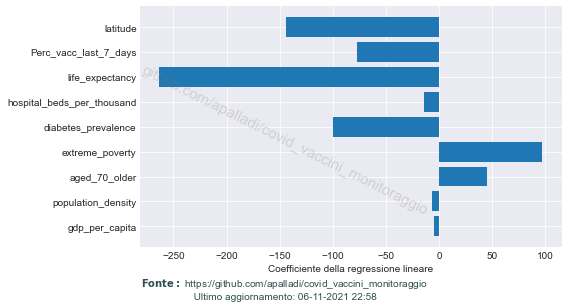

In [17]:
# Stampa grafico dei coefficienti
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(figsize=(8, 4))
plt.barh(X.columns, regr.coef_)
plt.xlabel('Coefficiente della regressione lineare')
plt.grid()
ax = plt.gca()
add_watermark(fig, ax.xaxis.label.get_fontsize())
plt.tight_layout()
plt.savefig('../risultati/coefficienti.png', dpi=300, bbox_inches="tight")
plt.show()

### Aggiungere statsmodels a requirements.txt

In [18]:
import statsmodels.api as sm
# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

                             OLS Regression Results                             
Dep. Variable:     Deaths_last_210_days   R-squared:                       0.946
Model:                              OLS   Adj. R-squared:                  0.918
Method:                   Least Squares   F-statistic:                     33.28
Date:                  Sat, 06 Nov 2021   Prob (F-statistic):           4.67e-09
Time:                          22:58:34   Log-Likelihood:                -158.91
No. Observations:                    27   AIC:                             337.8
Df Residuals:                        17   BIC:                             350.8
Df Model:                             9                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
